In [22]:
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

In [23]:
train_dir = '/content/drive/MyDrive/Dataset/Task_A/train'
val_dir = '/content/drive/MyDrive/Dataset/Task_A/val'

In [24]:
img_height, img_width = 150, 150
batch_size = 32
epochs_frozen = 10
epochs_finetune = 10
learning_rate = 1e-4

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='binary', shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='binary', shuffle=False
)

Found 3246 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [26]:
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [27]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

In [28]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [29]:
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [31]:
history_frozen = model.fit(
    train_generator,
    epochs=epochs_frozen,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5209 - loss: 0.8525

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - accuracy: 0.5219 - loss: 0.8510 - val_accuracy: 0.8673 - val_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.7599 - loss: 0.5000 - val_accuracy: 0.8791 - val_loss: 0.2893 - learning_rate: 1.0000e-04
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 396ms/step - accuracy: 0.8067 - loss: 0.4286 - val_accuracy: 0.8910 - val_loss: 0.2829 - learning_rate: 1.0000e-04
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.7993 - loss: 0.4243 - val_accuracy: 0.8981 - val_loss: 0.2780 - learning_rate: 1.0000e-04
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.8499 - loss: 0.3462 - val_accuracy: 0.8863 - val_loss: 0.2752 - learning_rate: 1.0000e-04
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 410ms/step - accuracy: 0.8440 - loss: 0.3535 - val_accuracy: 0.8957 - val_loss: 0.2696 - learning_rate: 1.0000e-04
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 388ms/step - 

In [36]:
for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=learning_rate * 0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# === Train (Fine-Tuning) ===
history_finetuned = model.fit(
    train_generator,
    epochs=epochs_finetune,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 579ms/step - accuracy: 0.8728 - loss: 0.3030 - val_accuracy: 0.8744 - val_loss: 0.3905 - learning_rate: 1.0000e-05
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.8812 - loss: 0.2783 - val_accuracy: 0.9194 - val_loss: 0.2484 - learning_rate: 1.0000e-05
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 409ms/step - accuracy: 0.9114 - loss: 0.2091 - val_accuracy: 0.8863 - val_loss: 0.4126 - learning_rate: 1.0000e-05
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 399ms/step - accuracy: 0.9066 - loss: 0.2211 - val_accuracy: 0.9076 - val_loss: 0.3060 - learning_rate: 1.0000e-05
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 422ms/step - accuracy: 0.9390 - loss: 0.1567 - val_accuracy: 0.9123 - val_loss: 0.2420 - learning_rate: 1.0000e-05
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.9160 - loss: 0.2132 - val_accuracy: 0.8981 - val_loss: 0.3640 - learning_rate: 1.0000e-05
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 40

102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 363ms/step

 Classification Report: Training
              precision    recall  f1-score   support

      female       0.88      0.99      0.93      1623
        male       0.99      0.86      0.92      1623

    accuracy                           0.93      3246
   macro avg       0.93      0.93      0.93      3246
weighted avg       0.93      0.93      0.93      3246



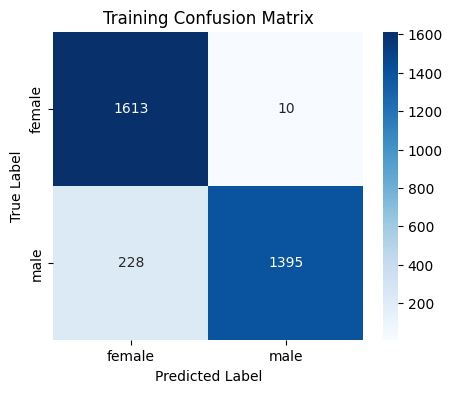

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step

 Classification Report: Validation
              precision    recall  f1-score   support

      female       0.78      0.73      0.76        79
        male       0.94      0.95      0.95       343

    accuracy                           0.91       422
   macro avg       0.86      0.84      0.85       422
weighted avg       0.91      0.91      0.91       422



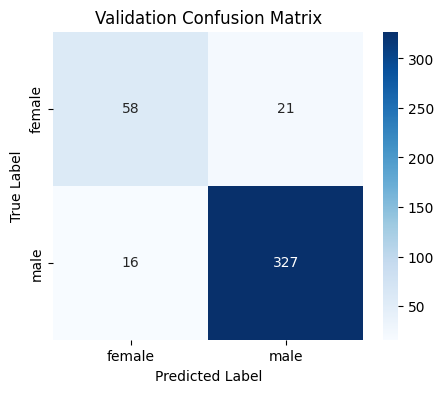

In [37]:
def generate_classification_report(generator, title="Validation"):
    y_true = generator.classes
    y_pred_prob = model.predict(generator)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print(f"\n Classification Report: {title}")
    print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys())))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate on Training & Validation
generate_classification_report(train_generator, title="Training")
generate_classification_report(val_generator, title="Validation")

In [ ]:
model.save('image_classification_model.h5')
print("Model saved successfully!")

In [38]:

# Save the trained model to Google Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model in your Google Drive
save_path = '/content/drive/MyDrive/trained file/Task_A_.keras' # You can change the filename

# Save the model
model.save(save_path)

print(f"Model saved successfully to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to: /content/drive/MyDrive/trained file/Task_A_.keras
